Follows from [single_exposure_modeling_test](single_exposure_modeling_test.ipynb) with [spectral_resampling_experiments](spectral_resampling_experiments.ipynb)  to try to speed up the interpolation step.

Most of the tests of the reliability are in those notebooks.

In [1]:
import os
from pathlib import Path

import numpy as np

from tqdm.notebook import tqdm

from astropy import units as u
from astropy.coordinates import SkyCoord
from astropy import table
from astropy import convolution
from astropy import visualization
from astropy import constants
from astropy.stats import sigma_clip
from astropy.io import fits

import specutils
from specutils import manipulation as specman
from specutils import analysis as specan

from spectres import spectres

from jwst import datamodels

import webbpsf

In [2]:
%matplotlib inline

visualization.quantity_support()
from matplotlib import pyplot as plt

In [3]:
data_dir = Path('widened_2')

test_path = list(data_dir.glob('*04101_00001_nrs2_cal.fits'))
assert len(test_path) == 1
test_path = test_path[0]

test_dm = datamodels.open(test_path)

example_slit = test_dm.slits[50]

In [4]:
wls = np.quantile(example_slit.wavelength[np.isfinite(example_slit.wavelength)], [0, .5,1])*u.micron

xdat, ydat = np.mgrid[:example_slit.data.shape[0], :example_slit.data.shape[1]]

## Make a PSF

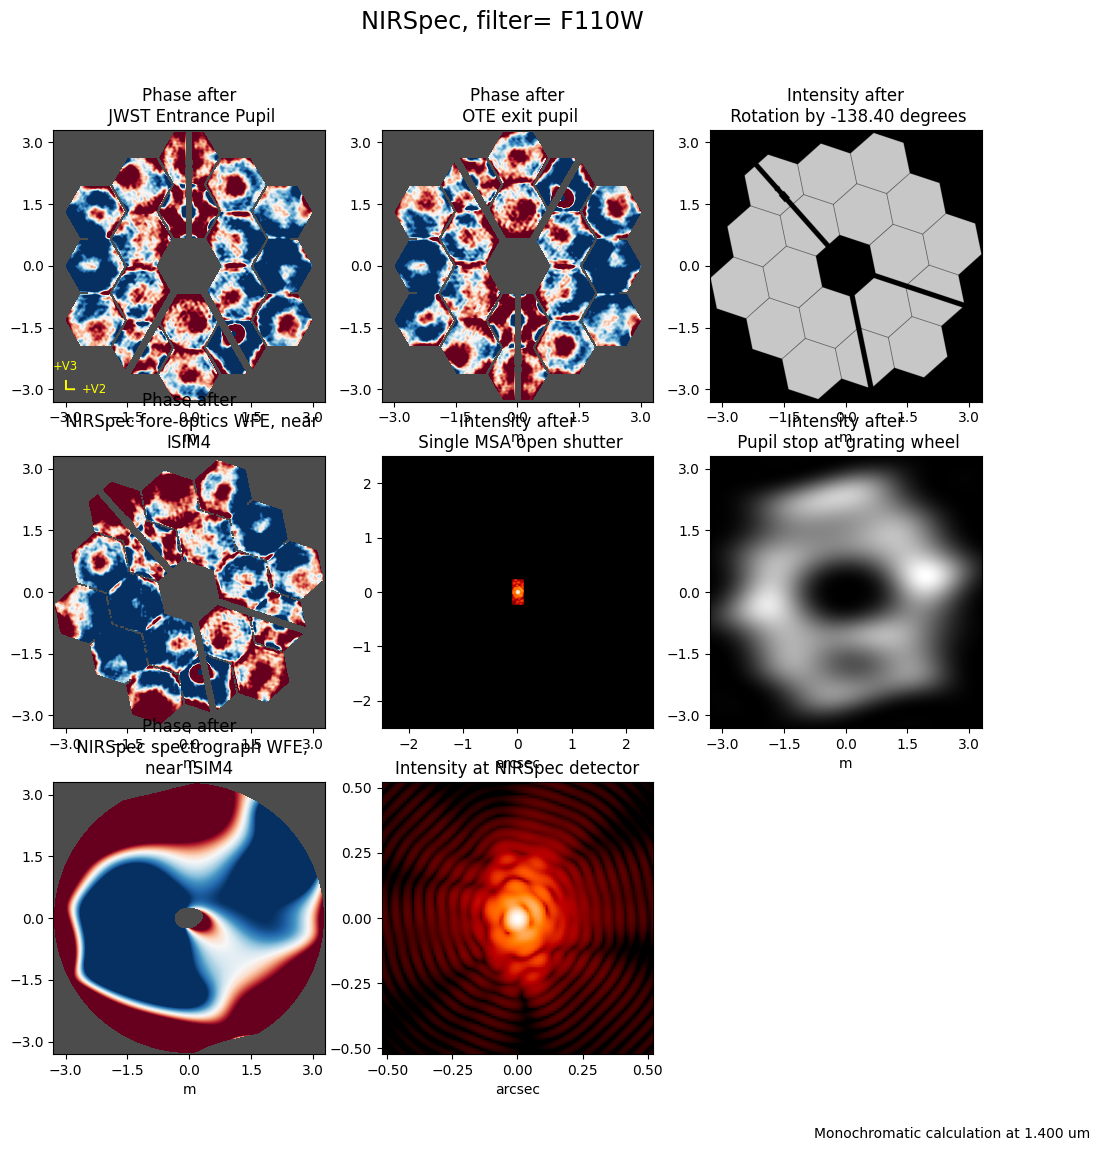

In [5]:
wns = webbpsf.NIRSpec()

wns.detector = 'NRS2'
wns.image_mask = 'Single MSA open shutter'

plt.figure(figsize=(12, 12))
psf0 = wns.calc_psf(monochromatic=(1.4*u.micron).to(u.meter).value, oversample=10, fov_arcsec=1, display=True)

In [6]:
psf0['OVERDIST'].header['PIXELSCL']

0.010430000000000002

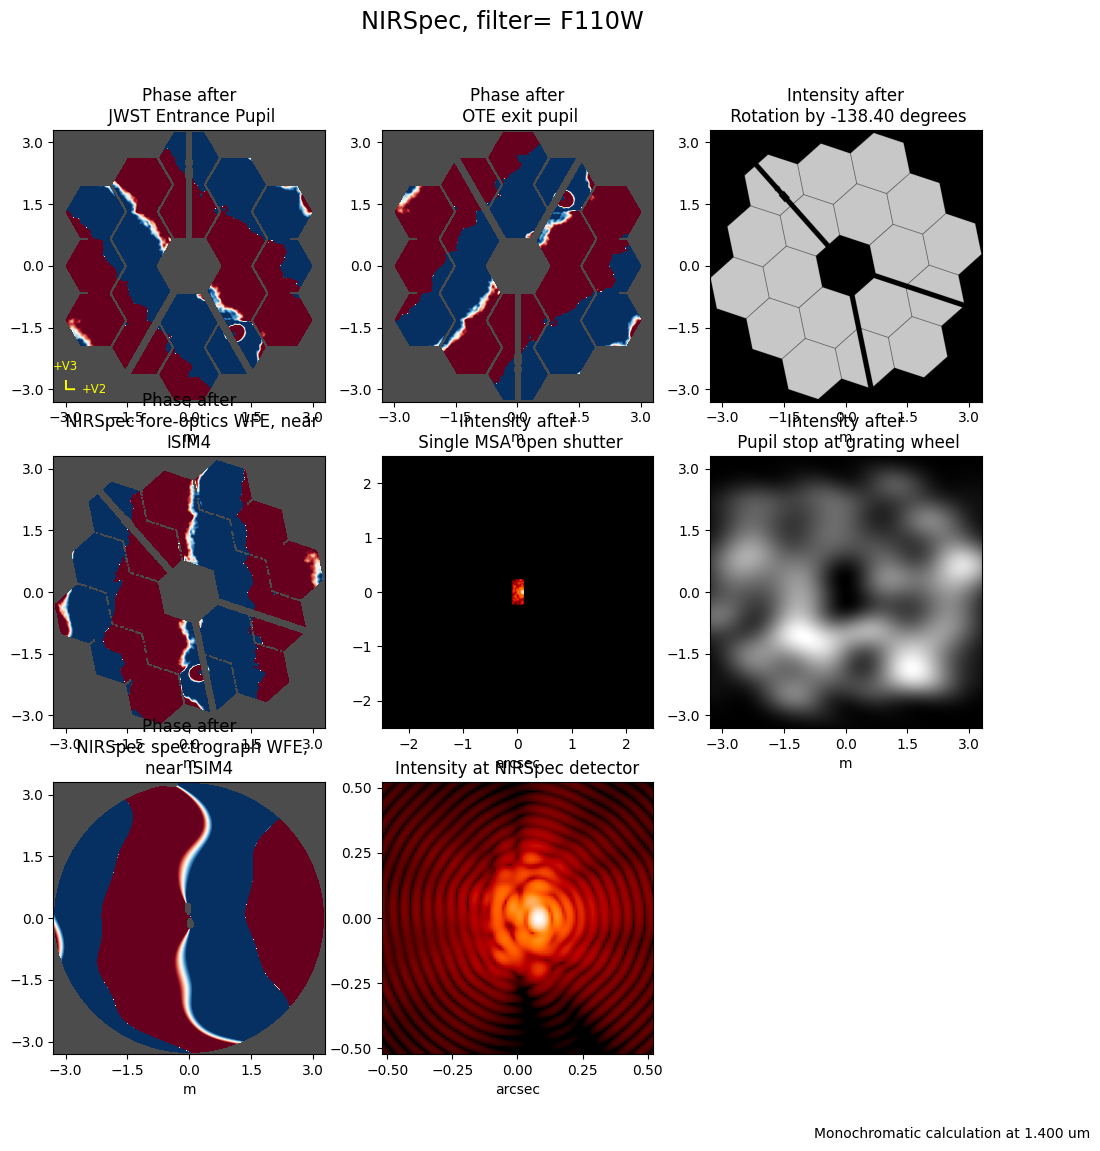

In [7]:
plt.figure(figsize=(12, 12))
wns.options['source_offset_x'] = psf0['OVERDIST'].header['PIXELSCL']*9  # 9 pixel offset, expressed in arcsec
wns.options['source_offset_y'] = 0.0
psf1 = wns.calc_psf(monochromatic=(1.4*u.micron).to(u.meter).value, oversample=10, fov_arcsec=1, display=True)

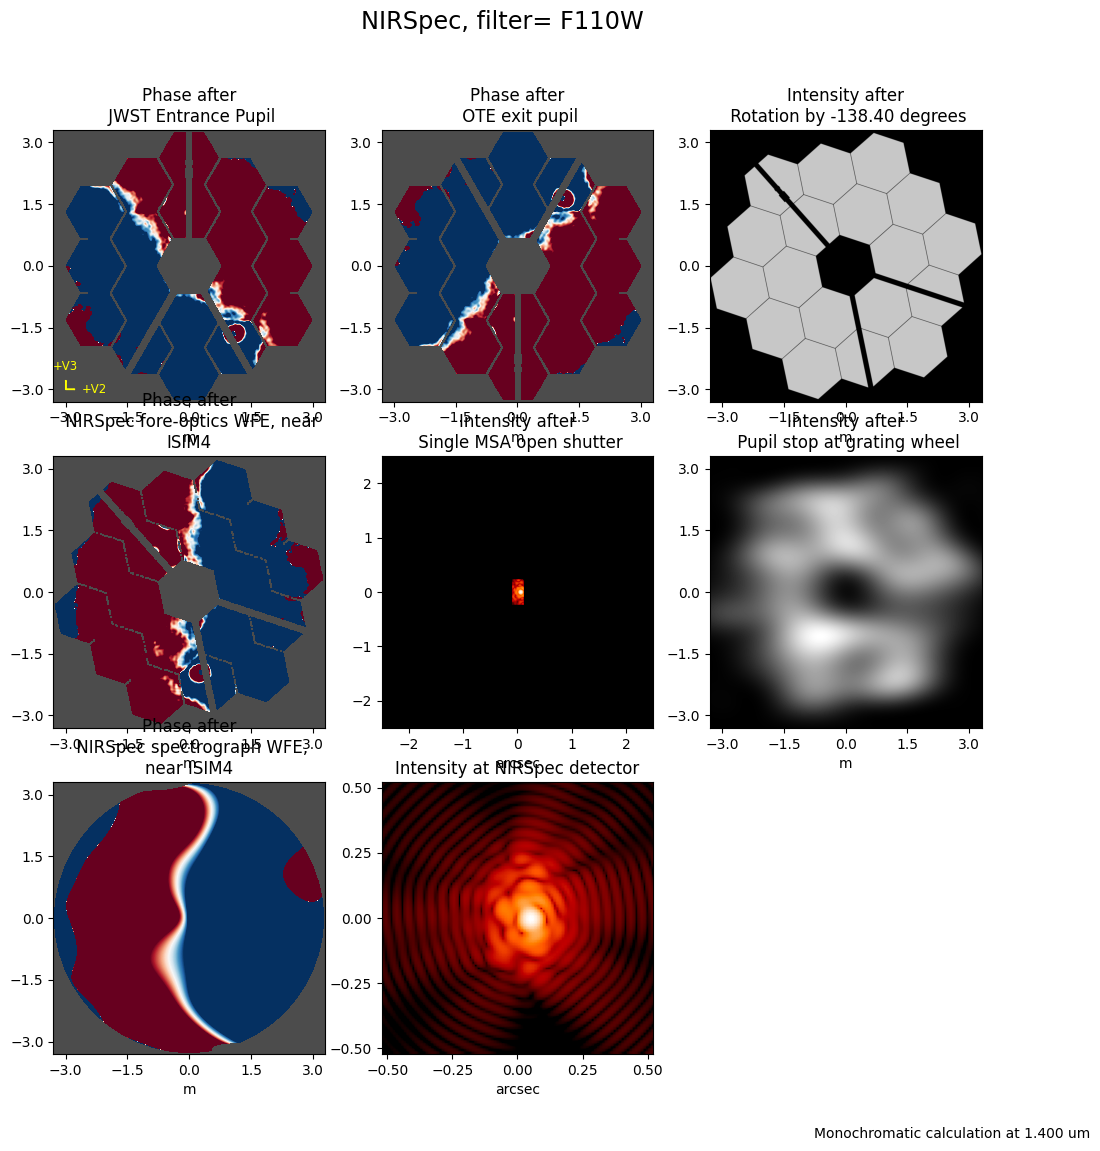

In [47]:
plt.figure(figsize=(12, 12))
wns.options['source_offset_x'] = psf0['OVERDIST'].header['PIXELSCL']*5  # 5 pixel offset, expressed in arcsec
wns.options['source_offset_y'] = 0.0
psf2 = wns.calc_psf(monochromatic=(1.4*u.micron).to(u.meter).value, oversample=10, fov_arcsec=1, display=True)

In [52]:
psf0n = psf0['OVERDIST'].data/np.max(psf0['OVERDIST'].data)
psf1n = psf1['OVERDIST'].data/np.max(psf1['OVERDIST'].data)
psf2n = psf2['OVERDIST'].data/np.max(psf2['OVERDIST'].data)

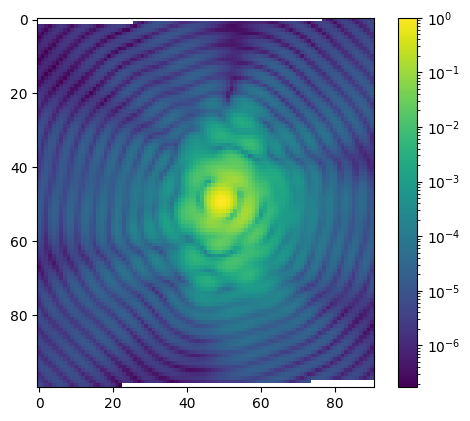

In [33]:
plt.imshow(psf0n[:,:-9], norm='log')
plt.colorbar();

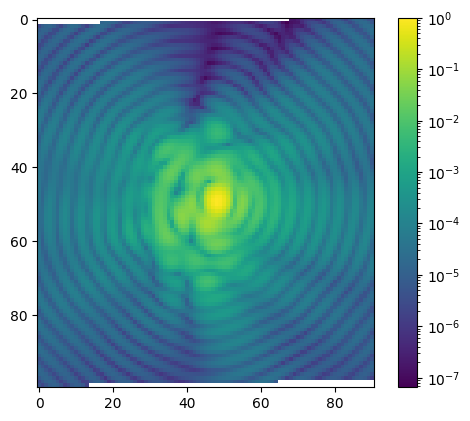

In [37]:
plt.imshow(psf1n[:, 9:], norm='log')
plt.colorbar();

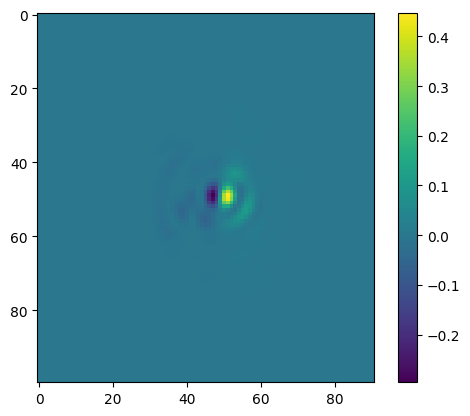

In [39]:
plt.imshow(psf0n[:,:-9] - psf1n[:, 9:])
plt.colorbar()

Whoa, definite offset.  Lets try what's the closest we can do?

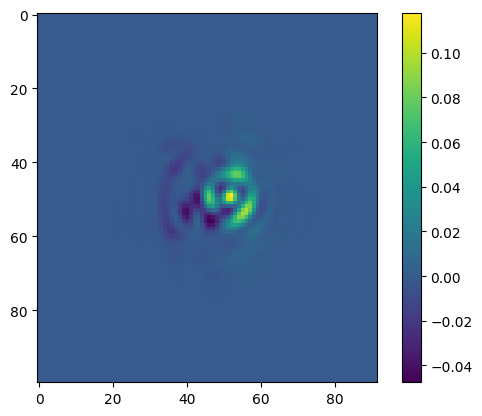

In [45]:
plt.imshow(psf0n[:,:-8] - psf1n[:, 8:])
plt.colorbar()

So that's a ~0.1 pixel ~10 marsec ~ 1 angstromish offset.  

What about the more mild case of half way to the slit edge?

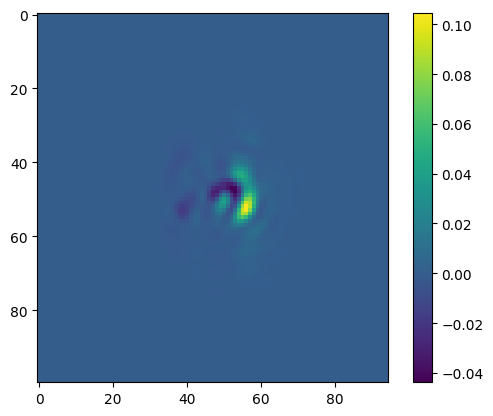

In [59]:
plt.imshow(psf0n[:,:-5] - psf2n[:, 5:])
plt.colorbar();

Closest integer pixel at least is that then.

## Look at where the various pointing directions are and how that maps onto the WCS

In [8]:
list(example_slit)

['barshadow',
 'data',
 'dither_position',
 'dq',
 'err',
 'int_times',
 'meta.aperture.name',
 'meta.aperture.position_angle',
 'meta.aperture.pps_name',
 'meta.bunit_data',
 'meta.bunit_err',
 'meta.cal_step.assign_wcs',
 'meta.cal_step.dark_sub',
 'meta.cal_step.dq_init',
 'meta.cal_step.gain_scale',
 'meta.cal_step.group_scale',
 'meta.cal_step.imprint',
 'meta.cal_step.ipc',
 'meta.cal_step.jump',
 'meta.cal_step.linearity',
 'meta.cal_step.msa_flagging',
 'meta.cal_step.ramp_fit',
 'meta.cal_step.refpix',
 'meta.cal_step.saturation',
 'meta.cal_step.superbias',
 'meta.calibration_software_revision',
 'meta.calibration_software_version',
 'meta.compress',
 'meta.coordinates.reference_frame',
 'meta.data_processing_software_version',
 'meta.date',
 'meta.dither.nod_type',
 'meta.dither.position_number',
 'meta.dither.primary_type',
 'meta.dither.total_points',
 'meta.dither.x_offset',
 'meta.dither.y_offset',
 'meta.ephemeris.reference_frame',
 'meta.ephemeris.spatial_x_bary',
 'me

In [9]:
example_slit.meta.pointing.pa_v3

89.41308823489375

In [10]:
example_slit.meta.aperture.position_angle

227.8811245572717

231.91403277769012

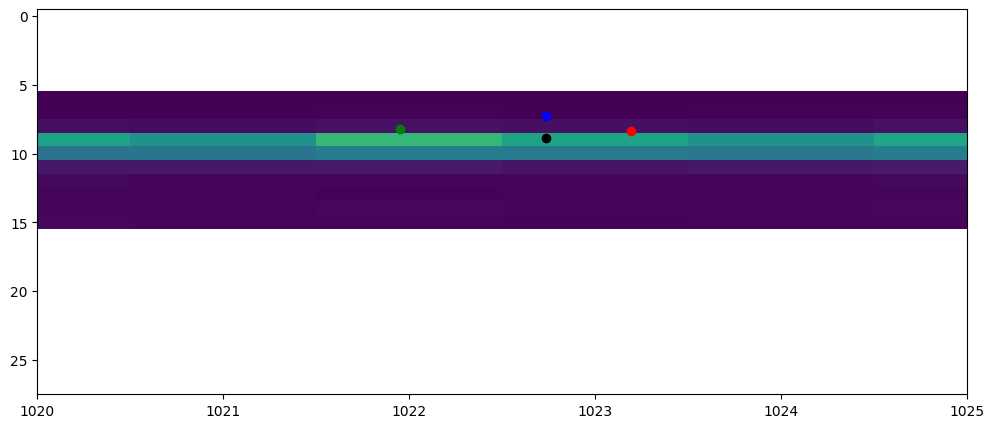

In [78]:
source_coo1 = SkyCoord(example_slit.source_ra, example_slit.source_dec, unit=u.deg)
x1, y1 = example_slit.meta.wcs.world_to_pixel(source_coo1, 1.4*u.micron)

source_coo2 = SkyCoord(example_slit.source_ra*u.deg + 0.1*u.arcsec, example_slit.source_dec*u.deg)
x2, y2 = example_slit.meta.wcs.world_to_pixel(source_coo2, 1.4*u.micron)

source_coo3 = SkyCoord(example_slit.source_ra*u.deg, example_slit.source_dec*u.deg + 0.1*u.arcsec)
x3, y3 = example_slit.meta.wcs.world_to_pixel(source_coo3, 1.4*u.micron)

source_coo4 = SkyCoord(example_slit.source_ra*u.deg + 0.172*u.arcsec, example_slit.source_dec*u.deg + 0.1*u.arcsec)
x4, y4 = example_slit.meta.wcs.world_to_pixel(source_coo4, 1.4*u.micron)

plt.figure(figsize=(12,5))
visualization.imshow_norm(example_slit.data, aspect='auto',
                          interval=visualization.PercentileInterval(99),
                          stretch=visualization.LinearStretch(),
                          interpolation='nearest',)
plt.scatter([x1], [y1], c='k')
plt.scatter([x2], [y2], c='r')
plt.scatter([x3], [y3], c='g')
plt.scatter([x4], [y4], c='b')
plt.xlim(1020, 1025)

source_coo4.position_angle(source_coo1).deg

Hmm... concerning that it's off by a few degrees? Might be in-flight vs JDox though